In [ ]:
import kagglehub

dataset_path = kagglehub.dataset_download('vipoooool/new-plant-diseases-dataset')
print('Path to dataset files:', dataset_path)

Path to dataset files: /root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
!pip install torchsummary
from torchsummary import summary

%matplotlib inline

In [ ]:
dataset = dataset_path + '/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_dataset = dataset + '/train'
valid_dataset = dataset + '/valid'
diseases = os.listdir(train_dataset)
print(diseases)

['Corn_(maize)___healthy', 'Grape___healthy', 'Strawberry___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Orange___Haunglongbing_(Citrus_greening)', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Tomato___Early_blight', 'Potato___Early_blight', 'Corn_(maize)___Common_rust_', 'Potato___healthy', 'Pepper,_bell___Bacterial_spot', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Potato___Late_blight', 'Tomato___Bacterial_spot', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Grape___Esca_(Black_Measles)', 'Peach___healthy', 'Cherry_(including_sour)___healthy', 'Squash___Powdery_mildew', 'Soybean___healthy', 'Tomato___Septoria_leaf_spot', 'Raspberry___healthy', 'Tomato___healthy', 'Apple___Apple_scab', 'Blueberry___healthy', 'Tomato___Leaf_Mold', 'Apple___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Grape___Black_rot', 

In [ ]:
print(f'Total disease classes are: {len(diseases)}')

Total disease classes are: 38


In [ ]:
plants = []
number_of_diseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        number_of_diseases += 1

In [ ]:
print(f'Unique Plants are: \n{plants}')

Unique Plants are: 
['Corn_(maize)', 'Grape', 'Strawberry', 'Orange', 'Tomato', 'Potato', 'Pepper,_bell', 'Peach', 'Apple', 'Cherry_(including_sour)', 'Squash', 'Soybean', 'Raspberry', 'Blueberry']


In [ ]:
print(f'Number of plants: {len(plants)}')

Number of plants: 14


In [ ]:
print(f'Number of diseases: {number_of_diseases}')

Number of diseases: 26


Text(0.5, 1.0, 'Images per each class of plant disease')

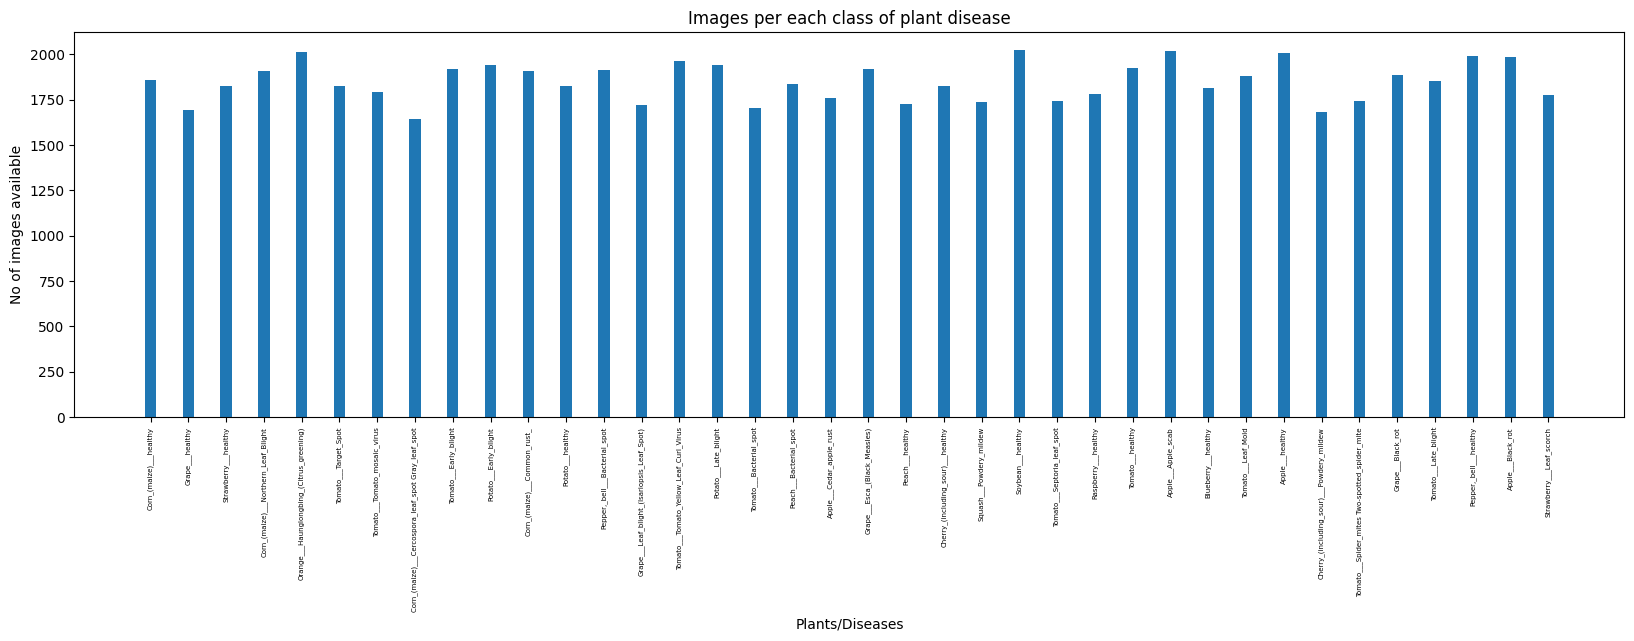

In [ ]:
# number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dataset + '/' + disease))

index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

In [ ]:
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Corn_(maize)___healthy,1859
Grape___healthy,1692
Strawberry___healthy,1824
Corn_(maize)___Northern_Leaf_Blight,1908
Orange___Haunglongbing_(Citrus_greening),2010
Tomato___Target_Spot,1827
Tomato___Tomato_mosaic_virus,1790
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,1642
Tomato___Early_blight,1920
Potato___Early_blight,1939


In [ ]:
n_train = 0
for value in nums.values():
    n_train += value
print(f'There are {n_train} images for training')

There are 70295 images for training


In [ ]:
# datasets for validation and training
train = ImageFolder(train_dataset)
valid = ImageFolder(valid_dataset)

In [ ]:
train[0]

(<PIL.Image.Image image mode=RGB size=256x256>, 0)

In [ ]:
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image)

Label :Apple___Apple_scab(0)


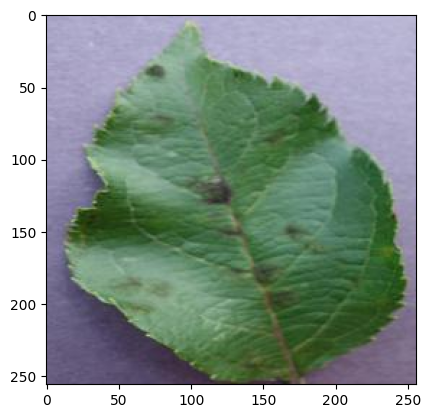

In [ ]:
show_image(*train[0])

Label :Apple___Black_rot(1)


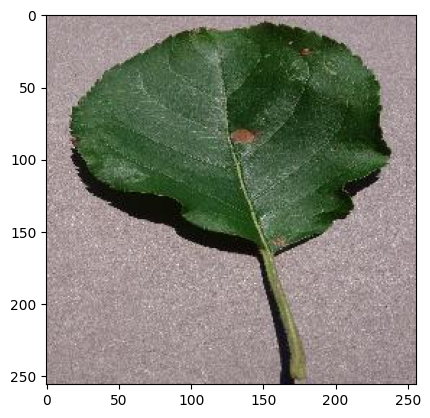

In [ ]:
show_image(*train[3000])

In [ ]:
# resize all images to a fixed size 32 and normalize using suitable mean and standard deviation for the dataset
img_size = 32
mean = [0.4670, 0.4735, 0.4662]
std = [0.2496, 0.2489, 0.2521]
preprocess = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

from tqdm.auto import tqdm

def preprocess_dataset(dataset):
    inputs = []
    for record in tqdm(dataset):
        image, label = record
        if image.mode == 'L':
            image = image.convert('RGB')
        input_tensor = preprocess(image)
        inputs.append([input_tensor, label])
    return inputs

# preprocess training and test dataset
train_inputs = preprocess_dataset(train)
valid_inputs = preprocess_dataset(valid)

  0%|          | 0/70295 [00:00<?, ?it/s]

  0%|          | 0/17572 [00:00<?, ?it/s]

In [ ]:
img, label = train_inputs[0]
print(img.shape, label)

torch.Size([3, 32, 32]) 0


In [ ]:
num_classes = train.classes
len(num_classes)

38

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
batch_size = 256

In [ ]:
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

In [ ]:
train_dl = DataLoader(train_inputs, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_inputs, batch_size=batch_size, shuffle=False)

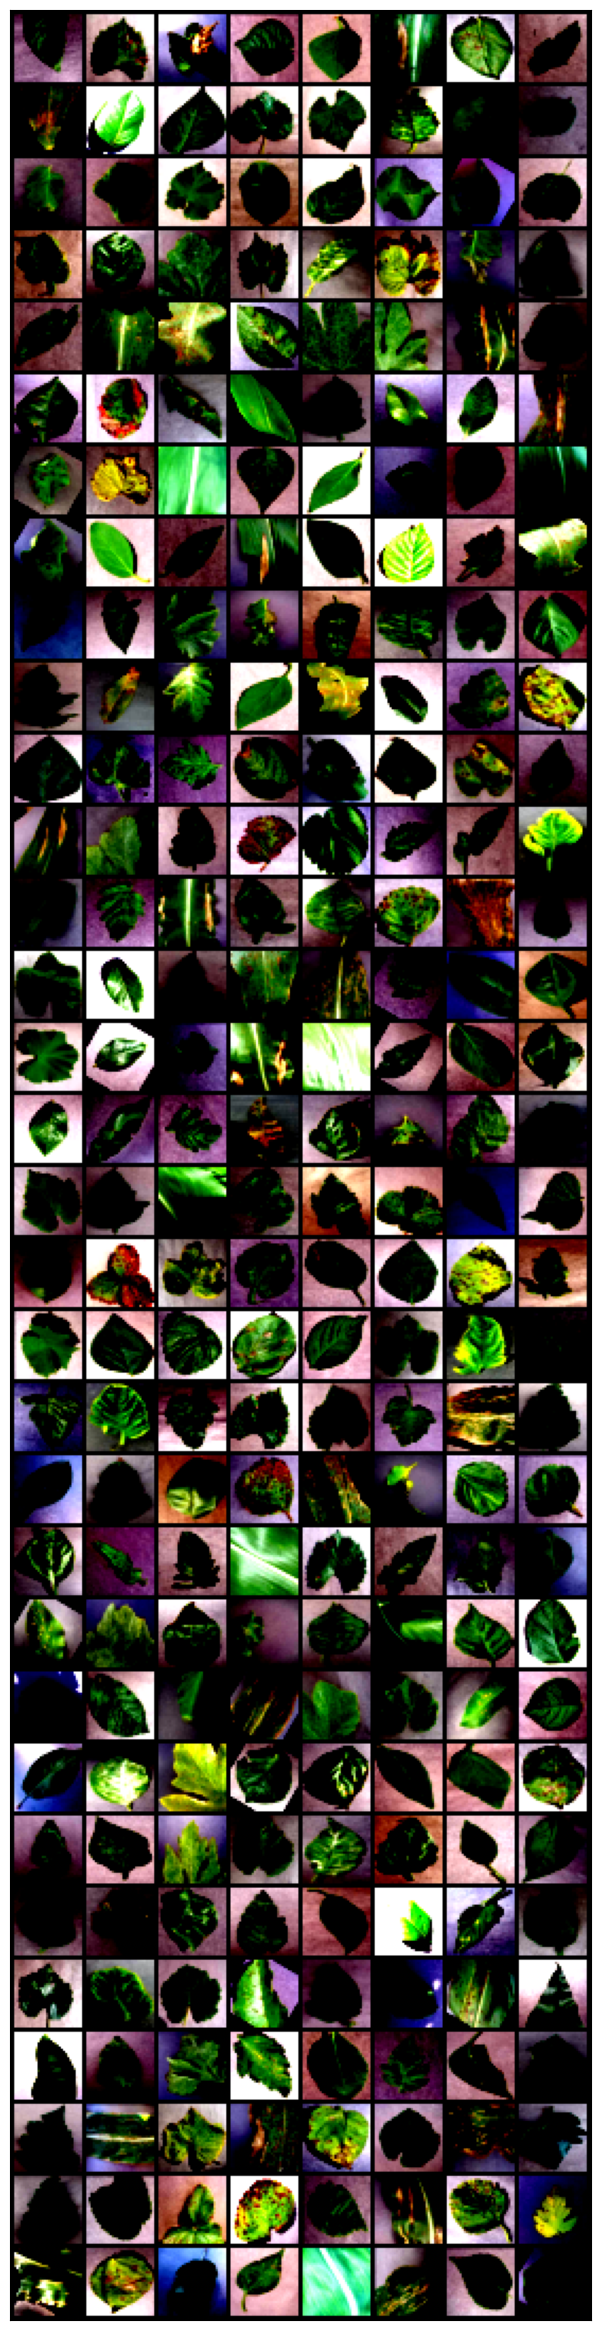

In [ ]:
show_batch(train_dl)

In [ ]:
import torch.nn as nn

# constructing ConvNet
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()

        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()

        self.conv_layer4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()

        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.dropout6 = nn.Dropout(p=0.5)
        self.fc6 = nn.Linear(in_features=2304, out_features=512)
        self.relu6 = nn.ReLU()

        self.dropout7 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(in_features=512, out_features=256)
        self.relu7 = nn.ReLU()

        self.fc8 = nn.Linear(in_features=256, out_features=num_classes)

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv_layer2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv_layer3(x)
        x = self.relu3(x)

        x = self.conv_layer4(x)
        x = self.relu4(x)

        x = self.conv_layer5(x)
        x = self.relu5(x)
        x = self.pool5(x)

        x = x.reshape(x.size(0), -1)

        x = self.dropout6(x)
        x = self.fc6(x)
        x = self.relu6(x)

        x = self.dropout7(x)
        x = self.fc7(x)
        x = self.relu7(x)

        x = self.fc8(x)

        return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ConvNet(num_classes=len(num_classes)).to(device)

print(summary(model, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 15, 15]               0
            Conv2d-4          [-1, 192, 15, 15]         110,784
              ReLU-5          [-1, 192, 15, 15]               0
         MaxPool2d-6            [-1, 192, 7, 7]               0
            Conv2d-7            [-1, 384, 7, 7]         663,936
              ReLU-8            [-1, 384, 7, 7]               0
            Conv2d-9            [-1, 256, 7, 7]         884,992
             ReLU-10            [-1, 256, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]         590,080
             ReLU-12            [-1, 256, 7, 7]               0
        MaxPool2d-13            [-1, 256, 3, 3]               0
          Dropout-14                 [-

In [ ]:
%%time

loss_func = nn.CrossEntropyLoss()
learning_rate = 0.008
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

num_epochs = 100
epoch_log = {}
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_dl):
        # move tensors to configured device
        images, labels = images.to(device), labels.to(device)

        # forward propagation
        outputs = model(images)
        loss = loss_func(outputs, labels)

        # backward propagation and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # check validation loss and acc of each epoch
    with torch.no_grad():
        # switch model to eval (not train) model
        model.eval()
        total, correct = 0, 0
        all_test_loss = []
        for images, labels in valid_dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            total += labels.size(0)
            # calc predictions
            predicted = torch.argmax(outputs, dim=1)
            # calc actual values
            correct += (predicted == labels).sum().item()
            # calc the loss
            all_test_loss.append(loss_func(outputs, labels).item())

        # calc test-loss
        mean_test_loss = sum(all_test_loss) / len(all_test_loss)
        # calc test-accuracy
        mean_test_acc = 100 * (correct / total)

    epoch_log[epoch] = {
        "epoch": epoch+1,
        "loss": round(loss.item(), 4),
        "test_loss": round(mean_test_loss, 4),
        "test_accuracy": round(mean_test_acc, 1)
    }
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test-Loss: {mean_test_loss:.4f}, Test-Accuracy: {mean_test_acc:.1f}%')

# save to file
torch.save(model, 'cnn.pt')

Epoch [1/100], Loss: 3.6392, Test-Loss: 3.6378, Test-Accuracy: 2.1%
Epoch [2/100], Loss: 3.6373, Test-Loss: 3.6373, Test-Accuracy: 4.7%
Epoch [3/100], Loss: 3.6366, Test-Loss: 3.6369, Test-Accuracy: 3.2%
Epoch [4/100], Loss: 3.6332, Test-Loss: 3.6365, Test-Accuracy: 3.9%
Epoch [5/100], Loss: 3.6395, Test-Loss: 3.6362, Test-Accuracy: 5.3%
Epoch [6/100], Loss: 3.6302, Test-Loss: 3.6358, Test-Accuracy: 4.1%
Epoch [7/100], Loss: 3.6371, Test-Loss: 3.6354, Test-Accuracy: 4.0%
Epoch [8/100], Loss: 3.6358, Test-Loss: 3.6349, Test-Accuracy: 4.3%
Epoch [9/100], Loss: 3.6357, Test-Loss: 3.6344, Test-Accuracy: 5.2%
Epoch [10/100], Loss: 3.6394, Test-Loss: 3.6337, Test-Accuracy: 6.0%
Epoch [11/100], Loss: 3.6379, Test-Loss: 3.6328, Test-Accuracy: 6.4%
Epoch [12/100], Loss: 3.6329, Test-Loss: 3.6316, Test-Accuracy: 6.2%
Epoch [13/100], Loss: 3.6317, Test-Loss: 3.6297, Test-Accuracy: 5.8%
Epoch [14/100], Loss: 3.6343, Test-Loss: 3.6261, Test-Accuracy: 5.6%
Epoch [15/100], Loss: 3.6175, Test-Loss: 3.

In [ ]:
epoch_log_df = pd.DataFrame(epoch_log).T
epoch_log_df

,epoch,loss,test_loss,test_accuracy
0,1.0,3.6392,3.6378,2.1
1,2.0,3.6373,3.6373,4.7
2,3.0,3.6366,3.6369,3.2
3,4.0,3.6332,3.6365,3.9
4,5.0,3.6395,3.6362,5.3
...,...,...,...,...
95,96.0,0.3273,0.2282,92.6
96,97.0,0.2507,0.2523,91.4
97,98.0,0.2973,0.2302,92.2
98,99.0,0.2821,0.2119,93.1


In [ ]:
# plot epoch accuracy
def plot_accuracies(epoch_log):
    accuracies = [x["test_accuracy"] for x in epoch_log.values()]
    plt.plot(accuracies, "-.")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. No. of epochs")

# plot epoch loss
def plot_losses(epoch_log):
    train_losses = [x["loss"] for x in epoch_log.values()]
    test_losses = [x["test_loss"] for x in epoch_log.values()]
    plt.plot(train_losses, "-.", label="Train")
    plt.plot(test_losses, "-.", label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs. No. of epochs")
    plt.legend(['Training', 'Validation'])

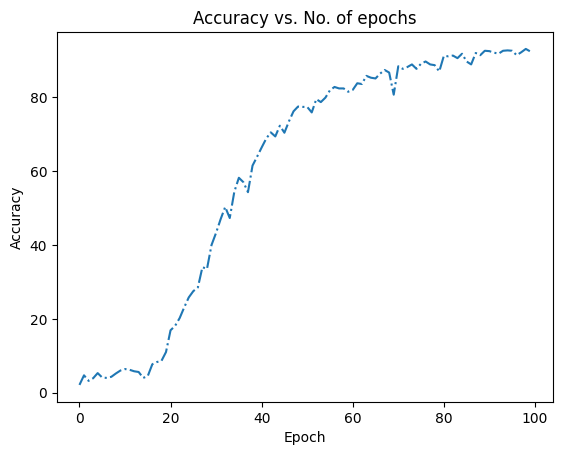

In [ ]:
plot_accuracies(epoch_log)

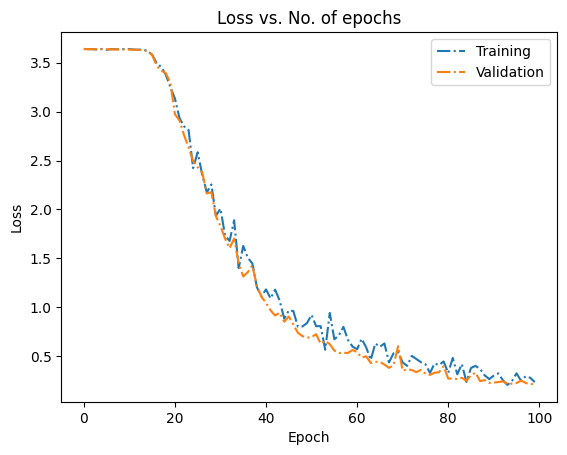

In [ ]:
plot_losses(epoch_log)

In [ ]:
def plot_metrics(epoch_log):
    # Extract metrics from log
    train_losses = [x.get('loss') for x in epoch_log.values()]
    val_losses = [x.get('test_loss') for x in epoch_log.values()]
    # train_accuracies = [x.get('train_accuracy') for x in epoch_log.values()]
    val_accuracies = [x.get('test_accuracy') for x in epoch_log.values()]

    # Plot Loss curves
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, '-.', label='Training Loss')
    plt.plot(val_losses, '-.', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs. Epochs')

    # Plot Accuracy curves
    plt.subplot(1, 2, 2)
    # plt.plot(train_accuracies, '-x', label='Training Accuracy')
    plt.plot(val_accuracies, '-.', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs. Epochs')

    plt.tight_layout()
    plt.show()

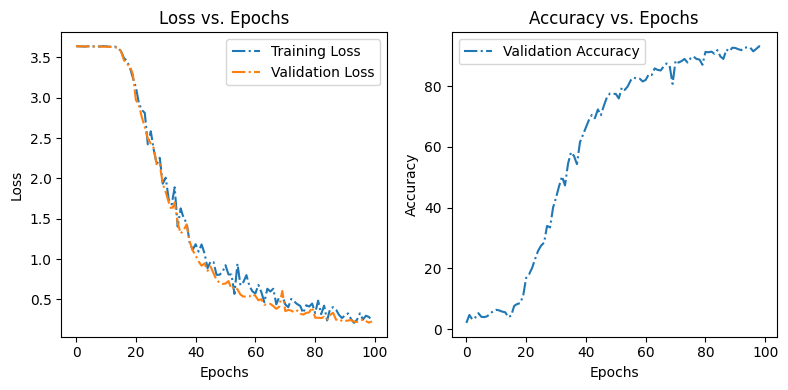

In [ ]:
plot_metrics(epoch_log)